# 🎦**AlloCiné Recommender System**🔎📍

Once we cleaned the data, we can start to build our recommender system. The data that will be used is located in the `../Cleaned Data/` folder.

**Types of Recommender System:**

There are two types of recommender system: **`content-based`** and **`collaborative-filtering`**.

- **`Content-based`:** this recommender system is based only on the characteristics of the products. Here, we will recommend an item to a user by comparing the features between items and recommend the items with the highest similarity. We will test two different methods:
    - Picking a random movie and recommending the ten most similar movies to it.
    - Forming a user profile vector based on the user's movie ratings and recommending the ten movies that fit best to the user's profile.
    
     

- **`Collaborative-filtering`:** this recommender system is based on the interactions between users and the items. 
    - `Memory-based`: Calculation of similarities between users or between products to recommend the right product.
        - `User-based CF`: Suggest products that have been well rated by similar users.
        - `Item-based CF`: Offer products that are well rated and similar to products already used.
    - `Model-based`: Finding a pattern explaining browsing and preferences behaviors.

By the format of our data, we will only be able to perform an `item-based CF` for the `memory-based` method as we don't have any information about the users, only their ratings and the features of the items.


---
# **Import libs**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import re
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances, euclidean_distances
from sklearn.preprocessing import normalize

from ast import literal_eval
from warnings import filterwarnings
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop # Used to get the French stop-words
from IPython.display import clear_output
import traceback

# We ignore dateparse warnings
filterwarnings("ignore",message="The localize method is no longer necessary, as this time zone supports the fold attribute")
# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
%matplotlib inline

# **Load the csv files**

In [2]:
def load_csv():
    '''
    Load the csv files and return a dict of dataframes.
    '''
    root_path = f"../Cleaned Data/"
    movies = pd.read_csv(f"{root_path}movies.csv", converters={"genres": literal_eval}) # Load list look-alike string as type list
    series = pd.read_csv(f"{root_path}series.csv", converters={"genres": literal_eval})
    for c in ["actors", "directors", "nationality"]:
        movies[c] = movies[c].apply(lambda x: literal_eval(x) if type(x) == str else [])
        series[c] = series[c].apply(lambda x: literal_eval(x) if type(x) == str else [])
    press_movies = pd.read_csv(f"{root_path}press_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_series.csv")
    #user_series = pd.read_csv(f"../Series/Ratings/Webscraping_Series_Ratings_user_ratings_series_#1-1.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

---
# **Content-based (CB)**

## **Functions:**

### Get stop-words: `get_stop_words()`

In [3]:
def get_stop_words():
    '''
    Get the French and English stop-words for tagging.
    :return: list of French and Enlish stop-words.
    '''
    # turn French stop-words into a list
    stop_words = list(fr_stop)
    # Load extra stop-words in French and in English
    with open("stop_words_french.txt",'r', encoding='UTF-8') as file:
        additional_stopwords = file.readlines()
        additional_stopwords = [line.rstrip() for line in additional_stopwords]
    with open("stop_words_eng.txt",'r', encoding='UTF-8') as file:
        additional_stopwords_eng = file.readlines()
        additional_stopwords_eng = [line.rstrip() for line in additional_stopwords_eng]
    
    # Add the additional French stop-words to the list of stop-words if they are not already in it
    for word, word_eng in zip(additional_stopwords,additional_stopwords_eng):
        if word not in stop_words:
            stop_words.append(word)
        if word_eng not in stop_words:
            stop_words.append(word_eng)
    stop_words.extend([""," ","#","-",":","(",")"])
    return stop_words

### Get tags: `get_tags(df, stop_words, cols_to_get)`

In [4]:
def get_tags(df: pd.DataFrame=None, stop_words: list=get_stop_words(), cols_to_get: str="title"):
    '''
    Get the tags of the movies from the title and/or summary.
    :param df: Dataframe to transform.
    :param stop_words: List of stop-words to remove from the tags.
    :param col_to_get: Columns to get the tags from.
    '''
    try:
        # We remove unecessary punctuation and characters from the title 
        # And store the title's keywords in a list
        rmv_char = r"(!|#|:|\$|\%|\^|\&|\*|\(|\)|-|\+|/|\?|\.+|\d)"
        df["tags"] = df[cols_to_get].apply(lambda x: re.split(" |,|\. |\.\.\.|\"|'|-", re.sub(rmv_char, " ", x)))
        df["tags"] = df["tags"].apply(lambda x: [i for i in x if i.lower() not in stop_words])
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
    return df

### Get dummies df: `get_dummies_df(df, kepp_cols, cols_to_dummies)`

In [5]:
def get_dummies_df(df_key: str="movies", keep_cols: list=None, cols_to_dummies: list=["genres"]):
    '''
    Get a dataframe with the dummies of the column cols_to_dummies.
    :param df_key: Key of the dataframe from dict 'data' to transform.
    :param keep_cols: List of columns to keep.
    :param cols_to_dummies: List of columns to transform to dummies.
    :return: Original dataframe with the concatenated dummies datframe of the columns cols_to_dummies.
    '''
    try:
        df_dummies = data[df_key][keep_cols]
        # We drop the movies with no user rating
        df_dummies = df_dummies.dropna(subset=["user_rating"], axis=0)
        df_dummies = df_dummies.reset_index(drop=True)
        # We keep only the release year as a recommendation feature
        df_dummies["release_date"] = df_dummies["release_date"].apply(lambda x: int(x.split("-")[0]))
        
        # We add the tag column to the dataframe
        if "tags" in cols_to_dummies:
            df_dummies = get_tags(df=df_dummies) 

        non_dummy_cols = df_dummies.shape[1]

        # We create binary variables for each cols_to_dummies feature by One-Hot encoding their values
        for col in cols_to_dummies:  
            encode_col = pd.get_dummies(df_dummies[col].apply(pd.Series).stack()).groupby(level=0).sum()
            df_dummies = pd.concat([df_dummies, encode_col], axis=1)
        
        # We sort the movies by title and release date
        df_dummies.sort_values(by=["title", "release_date"], ascending=[True,False]).reset_index(drop=True, inplace=True)                   
        
        # We replace NaN values in the dummy columns with 0
        df_dummies.iloc[:,non_dummy_cols:] = df_dummies.iloc[:,non_dummy_cols:].fillna(0)
        # We add +1 to the people who are both actors and directors for the same movie
        duplicated_cols = df_dummies.columns[df_dummies.columns.duplicated()]
        for col in duplicated_cols:
            df_dummies[col] = df_dummies[col].sum(axis=1)
        # We remove duplicated dummies columns (from people who are both actors and directors)
        df_dummies = df_dummies.loc[:,~df_dummies.columns.duplicated()].copy()
               
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()   
        return None
    return df_dummies

### Create utility matrix: `create_utility_matrix(v_type)`

In [6]:
def create_utility_matrix(v_type: str="movies", dummies_df: pd.DataFrame=None, matrix_type: str="user-item"):
    '''
    Create the utility matrix for the movies or series.
    :return: Utility matrix.
    '''
    try:
        users_df = data[f"user_{v_type}"].copy()
        # In the user_movies df, remove users who appears less than 5 times (=> have made less than 5 reviews)
        users_df = users_df.groupby('user_id').filter(lambda x: len(x) >= 5)        

        if matrix_type == "user-features":
            utility_matrix = pd.merge(users_df, dummies_df, left_on="movie_id", right_on="id", how="left")

        # Pivot table to get the user-movie utility matrix
        if matrix_type == "user-item":
            utility_matrix = users_df.pivot(index='user_id', columns='movie_id', values='user_rating').fillna(0)
            
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
        return None
    return utility_matrix

### Normalize: `normalize(matrix, dummies_df, binary, multiply_by_ratings, scaler, vectorize)`

In [7]:
def normalize_matrix(matrix: pd.DataFrame, dummies_df: pd.DataFrame=None, numerical_cols: list=[], cols_to_scale: list=[], binary: bool=False, multiply_by_ratings: bool=False, scaler: str="None", vectorize: bool=False):
    '''
    Normalize the matrix.
    :param matrix: Matrix to normalize.
    :param dummies_df: Dummies dataframe with ratings.
    :param numerical_cols: List of extra numerical columns we added to the dummies df.
    :param cols_to_scale: List of the numerical columns to scale.
    :param binary: If True, we normalize the matrix by dividing the term occurrence (1/0) by the number of features in the movie.
    :param multiply_by_ratings: If True, we multiply the matrix by the ratings of the movies.
    :param scaler: Method to use for normalization.
    :param vectorize: If True, we vectorize the matrix.
    :return: Normalized matrix or normalized user vector.
    '''
    try:
        scaled_matrix = matrix.copy()
        if binary: # Normalize the matrix by dividing the term occurrence (1/0) by the number of features in the movie.
            scaled_matrix.iloc[:,len(numerical_cols):] = scaled_matrix.iloc[:,len(numerical_cols):] / scaled_matrix.iloc[:,len(numerical_cols):].sum(axis=1).values[:,None]
        if multiply_by_ratings: # Weigh the features by the ratings of the movies.
            scaled_matrix.iloc[:,len(numerical_cols):] = scaled_matrix.iloc[:,len(numerical_cols):] * dummies_df["user_rating"].values[:,None]
        if vectorize: # We vectorize the matrix.
            user_vector = scaled_matrix.sum().values.reshape(1,-1)
            if scaler == "l1":
                user_vector = normalize(user_vector, axis=1, norm='l1')
            elif scaler == "l2":
                user_vector = normalize(user_vector, axis=1, norm='l2')
            
            
            return user_vector
        
        if scaler == "standard": # Apply standard normalization on the matrix and the cols_to_scale columns.         
            scaled_matrix.iloc[:,len(numerical_cols):] = (scaled_matrix.iloc[:,len(numerical_cols):] - scaled_matrix.iloc[:,len(numerical_cols):].mean(axis=0)) / scaled_matrix.iloc[:,len(numerical_cols):].std(axis=0)
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = (scaled_matrix[cols_to_scale] - scaled_matrix[cols_to_scale].mean(axis=0)) / scaled_matrix[cols_to_scale].std(axis=0)
        if scaler == "l1": # Apply standard normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = normalize(scaled_matrix.iloc[:,len(numerical_cols):], norm='l1',)
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = normalize(scaled_matrix[cols_to_scale], axis=1, norm='l1')
        if scaler == "l2": # Apply standard normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = normalize(scaled_matrix.iloc[:,len(numerical_cols):], norm='l2')
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = normalize(scaled_matrix[cols_to_scale], axis=1, norm='l2')
        elif scaler == "min-max": # Apply min-max normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = (scaled_matrix.iloc[:,len(numerical_cols):] - scaled_matrix.iloc[:,len(numerical_cols):].min(axis=0)) / (scaled_matrix.iloc[:,len(numerical_cols):].max(axis=0) - scaled_matrix.iloc[:,len(numerical_cols):].min(axis=0))
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = (scaled_matrix[cols_to_scale] - scaled_matrix[cols_to_scale].min(axis=0)) / (scaled_matrix[cols_to_scale].max(axis=0) - scaled_matrix[cols_to_scale].min(axis=0))
       
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
        return None
    return scaled_matrix

### Compute Similarity: `compute_similarity(feature_df, user_vector, similarity_metric)`

In [8]:
def compute_similarity(feature_df: pd.DataFrame=None, user_vector: np.array=None, similarity_metric: str="cosine"):
    '''
    Compute the similarity between the movies/series vectors.
    :param feature_df: Dataframe with the movies/series features to compute the similarity.
    :param user_vector: User vector to compute the similarity with the movies/series vectors.
    :param similarity_metric: Similarity metric to use (cosine|euclidean).
    :return: Similarity matrix between the movies/series vectors.
    '''
    try:
        # We compute the similarity between the user vector and the  movies/series vectors if user_vector is not None.
        if user_vector is not None:
            if similarity_metric == "cosine":
                return cosine_similarity(user_vector, feature_df)
            if similarity_metric == "euclidean":
                return euclidean_distances(user_vector, feature_df)      
            else:
                print(f"Error: {similarity_metric} is not a valid similarity metric.")        
        # We compute the similarity matrix between the movies/series vectors
        else:
            if similarity_metric == "cosine":
                return cosine_similarity(feature_df)
            if similarity_metric == "euclidean":
                return euclidean_distances(feature_df)        
            else:
                print(f"Error: {similarity_metric} is not a valid similarity metric.")    
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
        return None       

### Get CB recommendations: `CB_recommendations(title, sim_matrix, nb_recos, dummies_df)`

In [9]:
def CB_recommender(title: str="The Batman", sim_matrix: np.array=None, nb_recos: int=10, dummies_df: pd.DataFrame=None):
    '''
    Get the recommendations for a movie.
    :param title: Title of the movie to get the recommendations for.
    :param sim_matrix: Similarity matrix (cosine, euclidian, K-NN).
    :param nb_recos: Number of recommendations to get.
    :param dummies_df: Dataframe with the dummies of the movies.
    :return: Tuples of the recommended movies' titles, with similarity value and IDs.      
    '''
    CB_recos = [] # Initialization of the list of recommendations
    title_keywords = title.split(" ") # We split the title into keywords
    title_list = [] # Initialization of the list of titles
    movies_ids_list = [] # Initialization of the list of movie IDs
    # We collect all the movies titles (with their respective id) which contain all the keywords of the title variable
    for full_title, id in zip(dummies_df.title.values.tolist(), dummies_df.id.values.tolist()):
        if all(word.lower() in full_title.lower() for word in title_keywords):
            title_list.append((full_title,id))
    
    clear_output(wait=True)
    # If we get a direct match, we return the title.    
    if len(title_list) == 1:
        current_title = title_list[0]
    # Else, we get all the movies with similar names and ask the user to choose one.
    elif len(title_list) > 1:
        print("Several movies found with similar title. Please choose one of the following:")
        for i, item in enumerate(title_list,1):
            print(i, f': {item}', sep='',end='\n')
        choice = -1
        while choice < 1 or choice > len(title_list):
            choice = int(input("Enter the number of the movie: "))
        current_title = title_list[choice-1]
    else:
        return f'Error: The movie {title} requested was not found.'

    clear_output(wait=True)
    # If the movie is in the database
    idx = dummies_df.index[dummies_df.id == current_title[1]][0] # We retrieve the index of the movie by its id
    score_series = pd.Series(sim_matrix[idx]).drop(idx).sort_values(ascending=False) # We sort the similarity matrix of the movies and we drop the movie itself
    top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the top nb_recos movies 
    # We store the titles of the top nb_recos movies in the list CB_recos and return it
    for i in top_nbrecos:             
        CB_recos.append((dummies_df.title[i], sim_matrix[idx][i]))
        movies_ids_list.append(dummies_df.id[i])
    
    return (current_title[0],CB_recos), (current_title[1],movies_ids_list)

### Get CB user recommendations: `CB_user_recommendations(user_movies, dummies_df, nb_recos)`

In [10]:
def CB_user_recommendations(user_movies_df: pd.DataFrame, dummies_df: pd.DataFrame=None, feature_matrix: pd.DataFrame=None, norm_feature_matrix: pd.DataFrame=None, nb_recos: int=10):
    '''
    Get the recommendations for a user.
    :param user_movies_df: Dataframe of the user movie ratings with user and movie IDs.
    :param dummies_df: Dataframe with the dummies and average ratings of the movies.
    :param feature_matrix: Feature matrix of all the movies.
    :param nb_recos: Number of recommendations to get.
    :return: Tuples of the recommended movies' titles, with similarity value and IDs.   
    '''    
    CB_recos = [] # Initialization of the list of recommendations
    movies_ids_list = [] # Initialization of the list of movie IDs

    # In the user_movies df, remove users who appears less than 5 times (-> have made less than 5 reviews)
    user_movies = user_movies_df.groupby('user_id').filter(lambda x: len(x) >= 5)    
    # Get all unique user ids sorted by the descending number of reviews
    user_ids = user_movies.user_id.value_counts().index

    # Ask the user to choose a user
    index = -1
    while index < 0 or index > len(user_ids):
        index = int(input(f"Enter the number of the user you want to get recommendations for (between 1 and {len(user_ids)}): ")) - 1 
    # Get all movies ID from user ID and their ratings
    user_movie_list = user_movies[user_movies.user_id == user_ids[index]][["user_name","movie_id", "user_rating"]]
    # Get all movies rated by the user
    user_profile = dummies_df.loc[dummies_df["id"].isin(user_movie_list.movie_id.to_list())]    
    user_profile = user_profile.assign(user_rating=user_movie_list.user_rating.to_list())
    # We retrieve the feature matrix of the user profile
    features_user_matrix = feature_matrix.loc[user_profile.index]
    # We create and normalize the user profile
    norm_user_profile = normalize_matrix(features_user_matrix, dummies_df=user_profile, binary=False, multiply_by_ratings=True, scaler="l1", vectorize=True)

    # We compute the similarity between the user profile and the feature matrix
    sim_matrix = compute_similarity(norm_feature_matrix, norm_user_profile, similarity_metric="cosine")

    score_series = pd.Series(sim_matrix[0]).sort_values(ascending=False) # We sort the similarity matrix of the movies
    top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the top nb_recos movies 
    # We store the titles of the top nb_recos movies in the list CB_recos and return it
    for i in top_nbrecos:             
        CB_recos.append((dummies_df.title[i], sim_matrix[0][i]))
        movies_ids_list.append(dummies_df.id[i])
    
    return (user_movie_list.user_name.values[0],CB_recos), (None, movies_ids_list)

### Display recommendations: `display_recos(m_titles, m_ids)`

In [11]:
def display_recos(v_titles: tuple, v_ids: tuple, v_type: str="movies", reco_type: str="item-item"):
    '''
    Display the recommendations for a movie/series.
    :param v_titles: Tuple of the requested movie/series title and recommended movies/series titles.
    :param v_ids: Tuple of the requested movie/series id and recommended movies/series ids.    
    '''
    try:
        if reco_type == "item-item":
            #**************************************
            # We display the requested movie
            #**************************************
            f1 = plt.figure(figsize=(8,8))
            f1.suptitle("The movie you requested is:\n", fontsize=20, fontweight='bold')
            title = v_titles[0]
            split_title = title.split(" ")
            len_title = len(title)
            title = title if len_title <= 36 else " ".join(split_title[:len(split_title)//2]) + "\n" + " ".join(split_title[len(split_title)//2:])
            plt.title(title.title(), fontsize=15, fontweight='bold')
            plt.axis('off')
            plt.imshow(Image.open(glob.glob(f"../{v_type.title()}/Posters/*_{v_ids[0]}.jpg")[0]))

        #**************************************
        # We display the recommendations
        #**************************************    
        n = len(v_titles[1])
        f2 = plt.figure(figsize=(20,12))
        if reco_type == "item-item":
            f2.suptitle(f"If you like this movie, you might also like:", fontsize=20, fontweight='bold')
        elif reco_type == "user-item":
            f2.suptitle(f"Here are the {n} {v_type} recommendations for user '{v_titles[0]}'", fontsize=20, fontweight='bold')
        for i in range(n):
            f2.add_subplot(n//5,5,i+1)
            title = v_titles[1][i][0]
            split_title = title.split(" ")
            len_title = len(title)
            title = title if len_title <= 21 else " ".join(split_title[:len(split_title)//2]) + "\n" + " ".join(split_title[len(split_title)//2:])
            plt.title(title.title(),fontweight='bold')
            plt.axis('off')
            plt.text(0, 470, f"Similarity:\n{v_titles[1][i][1]}")
            plt.imshow(Image.open(glob.glob(f"../{v_type.title()}/Posters/*_{v_ids[1][i]}.jpg")[0]))

        plt.show(block=True)
    except Exception as e:
        print(e)
        traceback.print_exc()

## **Model CB N°1:** Genres with rating ponderation

In [ ]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep = ["id", "title", "release_date", "user_rating", "genres"]
v_type = "movies"

In [ ]:
movies_dummies = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep, cols_to_dummies=["genres"])

In [ ]:
features_matrix = movies_dummies.iloc[:,len(cols_to_keep):]
norm_features_matrix = normalize_matrix(features_matrix, dummies_df=movies_dummies, binary=True, multiply_by_ratings=False, scaler="None")

In [ ]:
# We compute the cosine similarity between each movie
sim_matrix = compute_similarity(norm_features_matrix, "cosine") 

In [ ]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix, nb_recos=10, dummies_df=movies_dummies)
display_recos(m_titles, m_ids, v_type=v_type)

The similarity between movies is very high, so a lot of movies with the highest similarity are recommended to the user. But depending on the original order of the movies, the order of the recommendations may change and therefore may not be very relevant. This is because we only considered the genres as a comparison criterion. We need to use more features or add a ponderation if we want to have a more accurate recommendation. 

So far, I obtained better recommendation by multiplying the correlation matrix by the movies' ratings. After reflexion, it appeared more sensible to multiply the encoded feature matrix by the ratings before computing the siùilarity. In that way, movies with the same genres will more likely be similar if they have a high rating.

## **Model CB N°2:** Model 1 + tag analysis

In [ ]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_2 = ["id", "title", "release_date", "user_rating", "genres", "summary"]
v_type = "movies"

In [ ]:
movies_dummies_2 = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep_2, cols_to_dummies=["genres", "tags"])

In [ ]:
features_matrix_2 = movies_dummies_2.iloc[:,len(cols_to_keep_2)+1:]
norm_features_matrix_2 = normalize_matrix(features_matrix_2, dummies_df=movies_dummies_2, binary=True, multiply_by_ratings=False, scaler="None")

In [ ]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
sim_matrix_2 = compute_similarity(norm_features_matrix_2, "cosine")

In [ ]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_2, nb_recos=10, dummies_df=movies_dummies_2)
display_recos(m_titles, m_ids, v_type=v_type)

In this second model, we used the titles of the movies to help recommend movies that, at first sight, may seem to talk about the same subject. What we notice from this new model is that movies with that share parts of their title are more likely to be recommended to the user, even though they have a lower rating. Moreover, as we decided to remove all punctuation marks and symbols characters, movies like `"X-Men"` will become `"X Men"`, and as both words are considered as stop-words, they will never be used to suggests on purpose other movies from the `"X-Men Saga"`. Movies with titles like `"Le Monde de Narnia : Chapitre 1 - Le lion, la sorcière blanche et l'armoire magique"` won't be affected by this characters removal.

## **Model CB N°3:** Model 1 + actors + directors + nationality

In [ ]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_3 = ["id", "title", "release_date", "duration", "user_rating", "genres", "actors", "directors", "nationality"]
v_type = "movies"

In [ ]:
movies_dummies_3 = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep_3, cols_to_dummies=["genres", "actors", "directors", "nationality",])

In [ ]:
numerical_cols = ["release_date", "duration"]
features_matrix_3 = movies_dummies_3[numerical_cols + movies_dummies_3.iloc[:,len(cols_to_keep_3):].columns.to_list()]
norm_features_matrix_3 = normalize_matrix(features_matrix_3, dummies_df=movies_dummies_3, numerical_cols=numerical_cols, 
                                    cols_to_scale=["release_date", "duration"] , binary=False, multiply_by_ratings=True, scaler="min-max")
norm_features_matrix_3

In [ ]:
features_matrix_3.sum().values

In [ ]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
sim_matrix_3 = compute_similarity(norm_features_matrix_3, similarity_metric="cosine")

In [ ]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_3, nb_recos=10, dummies_df=movies_dummies_3)
display_recos(m_titles, m_ids, v_type=v_type)

## **Model CB N°4:** Recommend movies from user profile

In [12]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_4 = ["id", "title", "release_date", "duration", "user_rating", "genres", "actors", "directors", "nationality"]
v_type = "movies"

In [13]:
movies_dummies_4 = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep_4, cols_to_dummies=["genres", "actors", "directors", "nationality"])

In [14]:
numerical_cols = []
# We retrieve the features matrix of the movies
features_matrix_4 = movies_dummies_4[numerical_cols + movies_dummies_4.iloc[:,len(cols_to_keep_4):].columns.to_list()]
# We normalize the features matrix
norm_features_matrix_4 = normalize_matrix(features_matrix_4, dummies_df=movies_dummies_4, numerical_cols=numerical_cols, 
                                    cols_to_scale=[] , binary=False, multiply_by_ratings=True, scaler="l1")
norm_features_matrix_4

,Action,Animation,Arts Martiaux,Aventure,Biopic,Bollywood,Comédie,Comédie dramatique,Comédie musicale,Divers,...,Tunisia,Turkey,USA,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Venezuela,Vietnam,West Germany
0,0.000000,0.000000,0.0,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.111111,0.111111,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.090909,0.000000,0.0,0.090909,0.0,0.0,0.090909,0.000000,0.0,0.0,...,0.0,0.0,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.090909,0.0,0.090909,0.0,0.0,0.090909,0.000000,0.0,0.0,...,0.0,0.0,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7893,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7894,0.000000,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7895,0.125000,0.000000,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.0,0.0,...,0.0,0.0,0.125000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7896,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


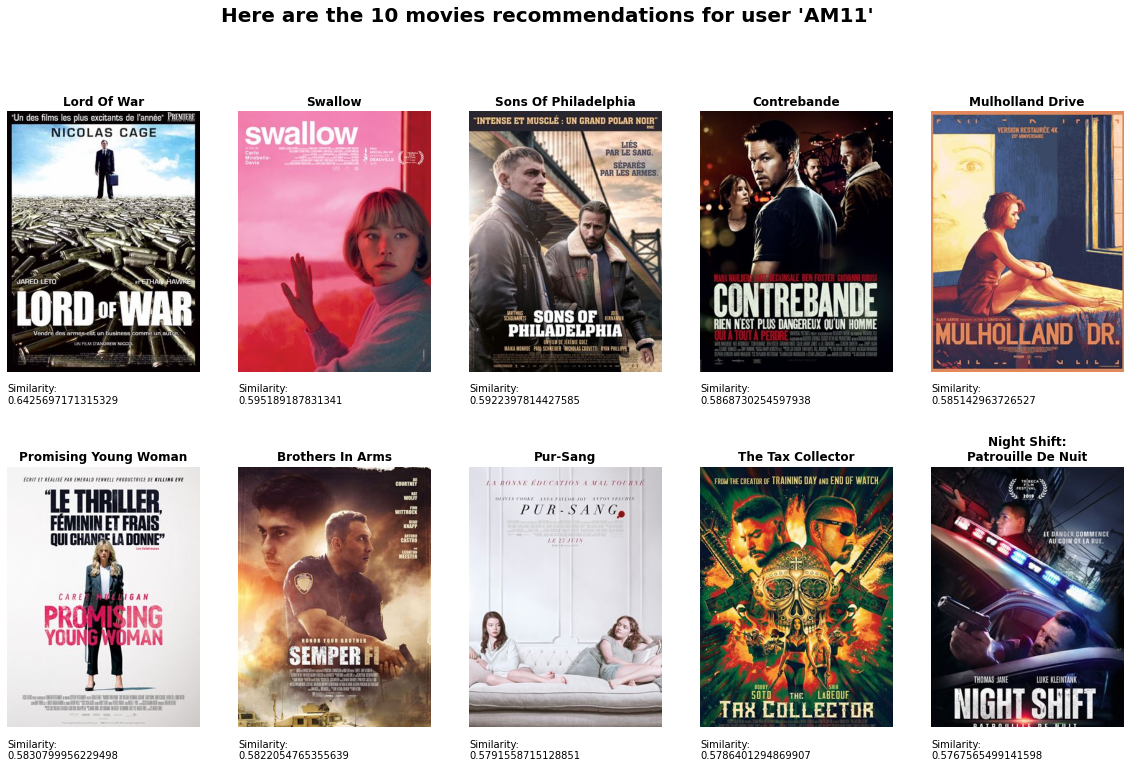

In [25]:
m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4, nb_recos=10)
display_recos(m_titles, m_ids, v_type=v_type, reco_type="user-item")

In [ ]:
# REMOVE ALREADY WATCHED MOVIES FROM SIMILARITY MATRIX

# **Collaborative-Filtering (CF)**

## **Model CF N°1:** *Memory-Based CF*

In [ ]:
# In the user_movies df, remove users who appears less than 5 times (=> have made less than 5 reviews)
user_movies = user_movies.groupby('user_id').filter(lambda x: len(x) >= 5)

In [ ]:
# Pivot table to get the user-movie utility matrix
interactions = user_movies.pivot(index='user_id', columns='movie_id', values='user_rating') 
interactions.T.describe()

In [ ]:
# We standardize the ratings before filling the missing values 
magnitude = np.sqrt(np.square(interactions).sum(axis=1))
interactions = interactions.divide(magnitude, axis='index')
interactions = interactions.fillna(0)

user_similarity = 1-pairwise_distances(interactions, metric='cosine')
item_similarity = 1-pairwise_distances(interactions.T, metric='cosine')

In [ ]:
magnitude

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1).values.reshape(-1, 1)
        ratings_diff = (ratings - mean_user_rating)
        pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred
    
user_prediction = predict(interactions, user_similarity, type='user')
item_prediction = predict(interactions, item_similarity, type='item')

In [ ]:
index_users = list(interactions.index.values)
index_movie_id = user_movies.movie_id.unique()
index_movies_title = movies[['id','title']].drop_duplicates()

In [ ]:
def MB_recommendations(user, prediction, nb_recos=10, index_users = index_users, index_movie_id = index_movie_id, index_movies_title = index_movies_title):
    # Similarity matrix
    user_similarity_df = pd.DataFrame(data=prediction, index=index_users, columns=index_movie_id)
    MB_recos = [] # Initialisation of the list of recommendations
    # If user in the database
    if user in user_similarity_df.index.values:
        score_series = pd.Series(user_similarity_df.loc[user]).sort_values(ascending=False) # We sort the similarity matrix
        top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the most similar nb_recos movies to the movies the user has already seen
        # We retrieve the titles of the top nb_recos movies in the list MB_recos and return it
        for i in top_nbrecos:
            MB_recos.append(index_movies_title[index_movies_title.id == i].title.iloc[0])
    else:
        print(f'The required user "{user}" is not in the database.')
    return MB_recos

In [ ]:
MB_recommendations("Z20030916115310953701324",user_prediction,10)

In [ ]:
MB_recommendations("Z20110828082536017359313",item_prediction,10)

In [ ]:
user_movies.user_id.value_counts()